# Computer vision for boat self navigating capabilities

## imports

In [5]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## navigation class

In [6]:
class visionNav:
    def __init__(self, image=None):
        self.image = image
        if self.image is None:
            raise ValueError("No image provided.")
        self.hsv_color = None
        self.mask_r = None
        self.mask_g = None

    
    def show_image(self, title=None):
        plt.imshow(cv.cvtColor(self.image, cv.COLOR_BGR2RGB))
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def generate_masks(self):
        if self.image is not None:

            image_bilateral = cv.bilateralFilter(self.image, 15, 350, 350)
            self.hsv_color = cv.cvtColor(image_bilateral, cv.COLOR_BGR2HSV)

            #green colorspace
            lower_g= np.array([40, 50, 0])
            upper_g = np.array([80, 255, 255])

            #red colorspace
            lower_r1 = np.array([0, 80, 0])
            upper_r1 = np.array([10, 255, 255])

            lower_r2 = np.array([170, 0, 20])
            upper_r2 = np.array([180, 255, 255])

            # green mask
            self.mask_g = cv.inRange(self.hsv_color, lower_g, upper_g)
            # red mask
            mask_r1 = cv.inRange(self.hsv_color, lower_r1, upper_r1)
            mask_r2 = cv.inRange(self.hsv_color, lower_r2, upper_r2)
            self.mask_r = mask_r1 | mask_r2
        else:
            print("No image loaded.")

    def detect(self, mask, min_area):
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv.contourArea(cnt) > min_area:
                x, y, w, h = cv.boundingRect(cnt)
                position = x + w // 2
                cv.rectangle(self.image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv.putText(self.image, 'detected', (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                return True, position
        return False
    
    def detect_buoys(self, min_area = 1000):

        green_detected = self.detect(self.mask_g, min_area)
        red_detected = self.detect(self.mask_r, min_area)
        
        if green_detected and red_detected:
            _, width, _ = self.image.shape
            if green_detected[1] < width // 2 and red_detected[1] > width // 2:
                print("Turn around!")
                self.show_image("Buoy Detection")
            elif green_detected[1] > width // 2 and red_detected[1] < width // 2:
                print("Keep course!")
                self.show_image("Buoy Detection")
        elif green_detected:
            print("Turn port!")
            self.show_image("Buoy Detection")
        elif red_detected:
            print("Turn starboard!")
            self.show_image("Buoy Detection")
        else:
            print("Stop!")
            self.show_image("Buoy Detection")
        return None

## Files in readable format

In [7]:
green = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoy green.png')
red = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoy red.png')
red_green = cv.imread('/home/salvador_cb/3_term/engineering_club/data/img/buoys.png')

## Main

Turn around!


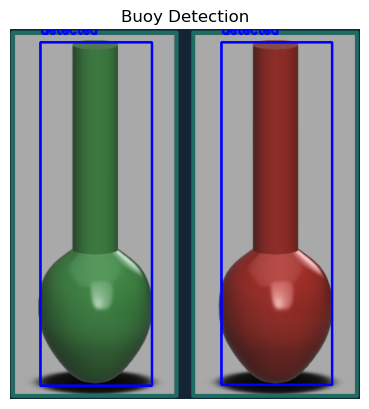

In [8]:
if __name__ == "__main__":
    nav = visionNav(image=red_green)
    nav.generate_masks()
    nav.detect_buoys(min_area=1000)